In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [203]:
import seaborn as sns

from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None) # display all columns

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

In [115]:
data = pd.read_csv('kobe.csv')

In [116]:
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [117]:
data.describe()
# data.info()

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id,shot_id
count,30697.000000,3.069700e+04,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,25697.000000,3.069700e+04,30697.000000
mean,249.190800,2.476407e+07,33.953192,7.110499,91.107535,-118.262690,4.885624,2.519432,0.146562,28.365085,13.437437,0.446161,1.610613e+09,15349.000000
std,150.003712,7.755175e+06,0.087791,110.124578,87.791361,0.110125,3.449897,1.153665,0.353674,17.478949,9.374189,0.497103,0.000000e+00,8861.604943
min,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.610613e+09,1.000000
25%,110.000000,2.050008e+07,33.884300,-68.000000,4.000000,-118.337800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,1.610613e+09,7675.000000
50%,253.000000,2.090035e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,1.610613e+09,15349.000000
75%,368.000000,2.960047e+07,34.040300,95.000000,160.000000,-118.174800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,1.610613e+09,23023.000000
max,659.000000,4.990009e+07,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000,1.610613e+09,30697.000000


In [118]:
data.set_index('shot_id', inplace=True)

**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge (с встроеной регуляризацией) на тех же признаках - построить сравнительную таблицу или график коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. 

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC
5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

Переведем часть колонок в тип категорий, а часть в тип object для оптимизации процесса обработки

In [119]:
data["action_type"] = data["action_type"].astype('object')
data["period"] = data["period"].astype('object')


vars_to_category = ["combined_shot_type", "game_event_id", "game_id", "playoffs", 
                    "season", "shot_made_flag", "shot_type", "team_id"]
for col in vars_to_category:
    data[col] = data[col].astype('category')

data.dtypes

action_type             object
combined_shot_type    category
game_event_id         category
game_id               category
lat                    float64
loc_x                    int64
loc_y                    int64
lon                    float64
minutes_remaining        int64
period                  object
playoffs              category
season                category
seconds_remaining        int64
shot_distance            int64
shot_made_flag        category
shot_type             category
shot_zone_area          object
shot_zone_basic         object
shot_zone_range         object
team_id               category
team_name               object
game_date               object
matchup                 object
opponent                object
dtype: object

In [164]:
data.head()
data.matchup.sort_values()

shot_id
4767       LAL @ ATL
10609      LAL @ ATL
10610      LAL @ ATL
10611      LAL @ ATL
10612      LAL @ ATL
            ...     
16273    LAL vs. WAS
16274    LAL vs. WAS
16275    LAL vs. WAS
6677     LAL vs. WAS
10105    LAL vs. WAS
Name: matchup, Length: 30697, dtype: object

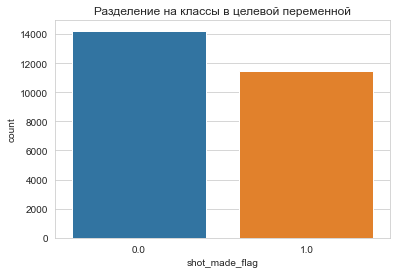

In [121]:
ax = plt.axes()
sns.countplot(x='shot_made_flag', data=data, ax=ax);
ax.set_title('Разделение на классы в целевой переменной')
plt.show()

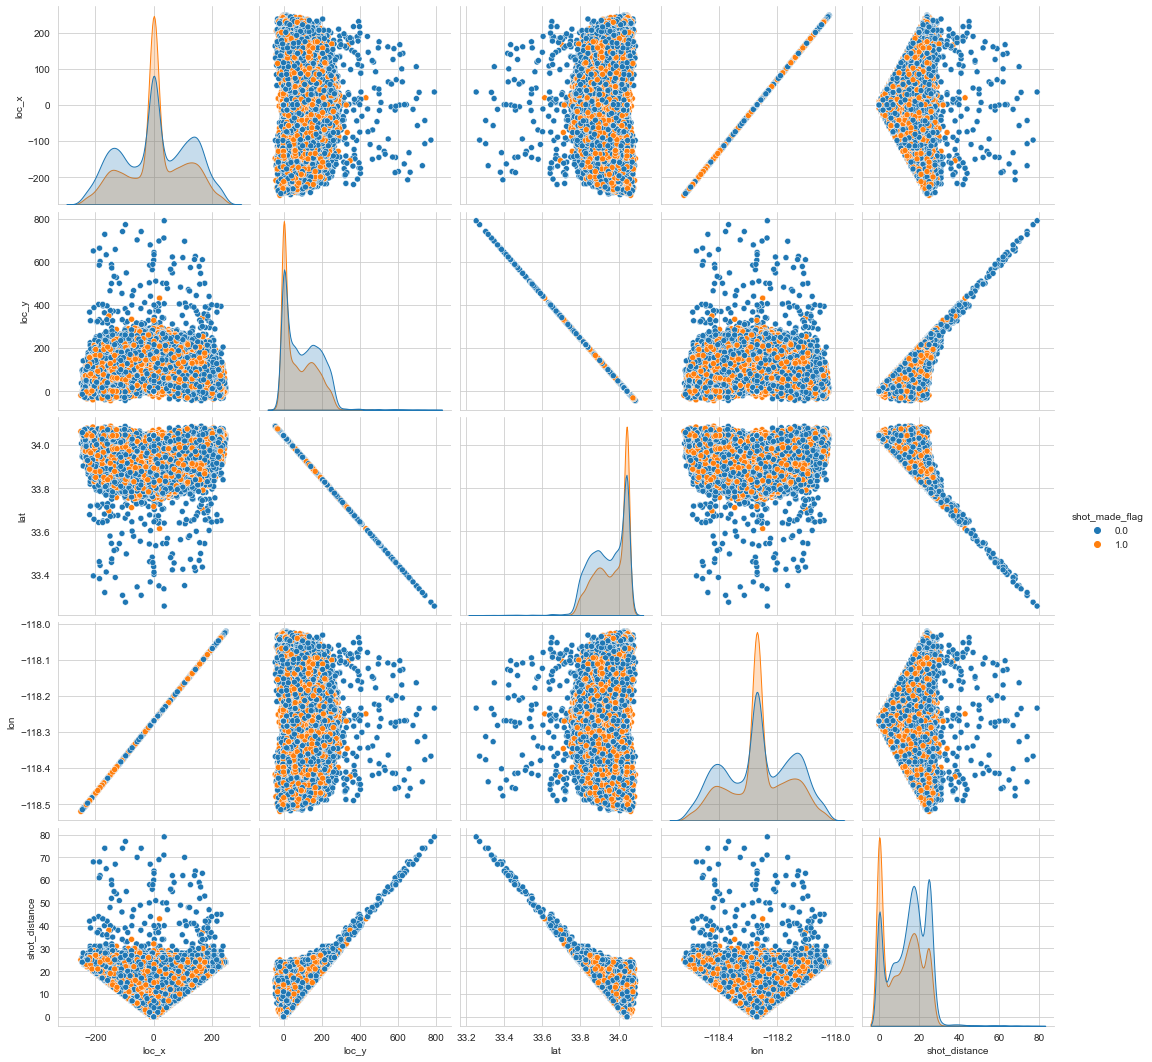

In [122]:
sns.pairplot(data, vars=['loc_x', 'loc_y', 'lat', 'lon', 'shot_distance'], hue='shot_made_flag', size=3)
plt.show()

Уберем лишние колонки, которые не несут для нас никакой смысловой нагрузки, поскольку никак не связаны и не коррелируют с целевой переменной.

In [165]:
data_cl = data.copy() # копируем DF
target = data_cl['shot_made_flag'].copy() # для некоторого удобства обзываем целевую переменную (Y), собственно, целевой переменной


data_cl.drop('team_id', axis=1, inplace=True) # всегда один и тот же номер
data_cl.drop('lat', axis=1, inplace=True) # аналогичен loc_x
data_cl.drop('lon', axis=1, inplace=True) # аналогичен loc_y
data_cl.drop('game_id', axis=1, inplace=True) # вообще пофиг
data_cl.drop('game_event_id', axis=1, inplace=True) # вообще пофиг
data_cl.drop('team_name', axis=1, inplace=True) # Всегда Lakers
data_cl.drop('shot_made_flag', axis=1, inplace=True) # убиваем целевую колонку из DF, который станет в итоге X

Создаем новые признаки.

In [166]:
# Оставшееся время
data_cl['seconds_from_period_end'] = 60 * data_cl['minutes_remaining'] + data_cl['seconds_remaining']
data_cl['last_5_sec_in_period'] = data_cl['seconds_from_period_end'] < 5 # последние 5 секунд в периоде

# убиваем ненужные теперь колонки
data_cl.drop('minutes_remaining', axis=1, inplace=True)
data_cl.drop('seconds_remaining', axis=1, inplace=True)
data_cl.drop('seconds_from_period_end', axis=1, inplace=True)

## Matchup - (away/home)
data_cl['home_play'] = data_cl['matchup'].str.contains('vs').astype('int')
data_cl['away_play'] = data_cl['matchup'].str.contains('@').astype('int')
data_cl.drop('matchup', axis=1, inplace=True)

# Работаем с датой игры
data_cl['game_date'] = pd.to_datetime(data_cl['game_date'])
data_cl['game_year'] = data_cl['game_date'].dt.year
data_cl['game_month'] = data_cl['game_date'].dt.month
data_cl.drop('game_date', axis=1, inplace=True)

# Loc_x, and loc_y binning
data_cl['loc_x'] = pd.cut(data_cl['loc_x'], 25)
data_cl['loc_y'] = pd.cut(data_cl['loc_y'], 25)

# Replace 20 least common action types with value 'Other'
rare_action_types = data_cl['action_type'].value_counts().sort_values().index.values[:20]
data_cl.loc[data_cl['action_type'].isin(rare_action_types), 'action_type'] = 'Other'

Применим one hot encoding для категориальных переменных

In [167]:
categorial_cols = [
    'action_type', 'combined_shot_type', 'period', 'season', 'shot_type',
    'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'game_year',
    'game_month', 'opponent', 'loc_x', 'loc_y']

for cc in categorial_cols:
    dummies = pd.get_dummies(data_cl[cc])
    dummies = dummies.add_prefix("{}#".format(cc))
    data_cl.drop(cc, axis=1, inplace=True)
    data_cl = data_cl.join(dummies)

In [138]:
data_cl.head()

,playoffs,shot_distance,last_5_sec_in_period,home_play,away_play,action_type#Alley Oop Dunk Shot,action_type#Alley Oop Layup shot,action_type#Driving Dunk Shot,action_type#Driving Finger Roll Layup Shot,action_type#Driving Finger Roll Shot,action_type#Driving Jump shot,action_type#Driving Layup Shot,action_type#Driving Reverse Layup Shot,action_type#Driving Slam Dunk Shot,action_type#Dunk Shot,action_type#Fadeaway Bank shot,action_type#Fadeaway Jump Shot,action_type#Finger Roll Layup Shot,action_type#Finger Roll Shot,action_type#Floating Jump shot,action_type#Follow Up Dunk Shot,action_type#Hook Shot,action_type#Jump Bank Shot,action_type#Jump Hook Shot,action_type#Jump Shot,action_type#Layup Shot,action_type#Other,action_type#Pullup Jump shot,action_type#Putback Layup Shot,action_type#Reverse Dunk Shot,action_type#Reverse Layup Shot,action_type#Reverse Slam Dunk Shot,action_type#Running Bank shot,action_type#Running Dunk Shot,action_type#Running Hook Shot,action_type#Running Jump Shot,action_type#Running Layup Shot,action_type#Slam Dunk Shot,action_type#Step Back Jump shot,action_type#Tip Shot,action_type#Turnaround Bank shot,action_type#Turnaround Fadeaway shot,action_type#Turnaround Jump Shot,combined_shot_type#Bank Shot,combined_shot_type#Dunk,combined_shot_type#Hook Shot,combined_shot_type#Jump Shot,combined_shot_type#Layup,combined_shot_type#Tip Shot,period#1,period#2,period#3,period#4,period#5,period#6,period#7,season#1996-97,season#1997-98,season#1998-99,season#1999-00,season#2000-01,season#2001-02,season#2002-03,season#2003-04,season#2004-05,season#2005-06,season#2006-07,season#2007-08,season#2008-09,season#2009-10,season#2010-11,season#2011-12,season#2012-13,season#2013-14,season#2014-15,season#2015-16,shot_type#2PT Field Goal,shot_type#3PT Field Goal,shot_zone_area#Back Court(BC),shot_zone_area#Center(C),shot_zone_area#Left Side Center(LC),shot_zone_area#Left Side(L),shot_zone_area#Right Side Center(RC),shot_zone_area#Right Side(R),shot_zone_basic#Above the Break 3,shot_zone_basic#Backcourt,shot_zone_basic#In The Paint (Non-RA),shot_zone_basic#Left Corner 3,shot_zone_basic#Mid-Range,shot_zone_basic#Restricted Area,shot_zone_basic#Right Corner 3,shot_zone_range#16-24 ft.,shot_zone_range#24+ ft.,shot_zone_range#8-16 ft.,shot_zone_range#Back Court Shot,shot_zone_range#Less Than 8 ft.,game_year#1996,game_year#1997,game_year#1998,game_year#1999,game_year#2000,game_year#2001,game_year#2002,game_year#2003,game_year#2004,game_year#2005,game_year#2006,game_year#2007,game_year#2008,game_year#2009,game_year#2010,game_year#2011,game_year#2012,game_year#2013,game_year#2014,game_year#2015,game_year#2016,game_month#1,game_month#2,game_month#3,game_month#4,game_month#5,game_month#6,game_month#10,game_month#11,game_month#12,opponent#ATL,opponent#BKN,opponent#BOS,opponent#CHA,opponent#CHI,opponent#CLE,opponent#DAL,opponent#DEN,opponent#DET,opponent#GSW,opponent#HOU,opponent#IND,opponent#LAC,opponent#MEM,opponent#MIA,opponent#MIL,opponent#MIN,opponent#NJN,opponent#NOH,opponent#NOP,opponent#NYK,opponent#OKC,opponent#ORL,opponent#PHI,opponent#PHX,opponent#POR,opponent#SAC,opponent#SAS,opponent#SEA,opponent#TOR,opponent#UTA,opponent#VAN,opponent#WAS,"loc_x#(-250.498, -230.08]","loc_x#(-230.08, -210.16]","loc_x#(-210.16, -190.24]","loc_x#(-190.24, -170.32]","loc_x#(-170.32, -150.4]","loc_x#(-150.4, -130.48]","loc_x#(-130.48, -110.56]","loc_x#(-110.56, -90.64]","loc_x#(-90.64, -70.72]","loc_x#(-70.72, -50.8]","loc_x#(-50.8, -30.88]","loc_x#(-30.88, -10.96]","loc_x#(-10.96, 8.96]","loc_x#(8.96, 28.88]","loc_x#(28.88, 48.8]","loc_x#(48.8, 68.72]","loc_x#(68.72, 88.64]","loc_x#(88.64, 108.56]","loc_x#(108.56, 128.48]","loc_x#(128.48, 148.4]","loc_x#(148.4, 168.32]","loc_x#(168.32, 188.24]","loc_x#(188.24, 208.16]","loc_x#(208.16, 228.08]","loc_x#(228.08, 248.0]","loc_y#(-44.835, -10.6]","loc_y#(-10.6, 22.8]","loc_y#(22.8, 56.2]","loc_y#(56.2, 89.6]","loc_y#(89.6, 123.0]","loc_y#(123.0, 156.4]","loc_y#(156.4, 189.8]","loc_y#(189.8, 223.2]","lo

In [168]:
unknown_mask = data['shot_made_flag'].isnull()

In [169]:
# Можно было, конечно и дропнуть просто
data_submit = data_cl[unknown_mask]

# Раделяем на X и Y
X = data_cl[~unknown_mask]
Y = target[~unknown_mask]

Определим список признаков, у которых разброс значений больше 90%

In [172]:
threshold = 0.90
vt = VarianceThreshold().fit(X)

# Find feature names
feat_var_threshold = data_cl.columns[vt.variances_ > threshold * (1-threshold)]
# feat_var_threshold
for f in feat_var_threshold:
    print('- '+f)


- playoffs
- shot_distance
- home_play
- away_play
- action_type#Jump Shot
- combined_shot_type#Jump Shot
- combined_shot_type#Layup
- period#1
- period#2
- period#3
- period#4
- shot_type#2PT Field Goal
- shot_type#3PT Field Goal
- shot_zone_area#Center(C)
- shot_zone_area#Left Side Center(LC)
- shot_zone_area#Left Side(L)
- shot_zone_area#Right Side Center(RC)
- shot_zone_area#Right Side(R)
- shot_zone_basic#Above the Break 3
- shot_zone_basic#In The Paint (Non-RA)
- shot_zone_basic#Mid-Range
- shot_zone_basic#Restricted Area
- shot_zone_range#16-24 ft.
- shot_zone_range#24+ ft.
- shot_zone_range#8-16 ft.
- shot_zone_range#Less Than 8 ft.
- game_month#1
- game_month#2
- game_month#3
- game_month#4
- game_month#11
- game_month#12
- loc_x#(-10.96, 8.96]
- loc_y#(-10.6, 22.8]
- loc_y#(22.8, 56.2]
- loc_y#(123.0, 156.4]


Найдем 20 самых важных признаков, используя разные модели.

Random Forest:

In [161]:
model = RandomForestClassifier()
model.fit(X, Y)

feature_imp = pd.DataFrame(model.feature_importances_, index=X.columns, columns=["importance"])
feat_imp_20 = feature_imp.sort_values("importance", ascending=False).head(20).index
for i in range(len(feat_imp_20)-1):
    print(f"{feat_imp_20[i]}\t- {model.feature_importances_[i]:.4f}")


shot_distance	- 0.0938
action_type#Jump Shot	- 0.0355
action_type#Layup Shot	- 0.0204
playoffs	- 0.0213
period#3	- 0.0165
opponent#SAS	- 0.0089
game_month#4	- 0.0242
opponent#PHX	- 0.0227
period#2	- 0.0232
period#1	- 0.0225
game_month#1	- 0.0228
loc_y#(-10.6, 22.8]	- 0.0275
period#4	- 0.0199
game_month#12	- 0.0226
game_month#3	- 0.0240
game_month#11	- 0.0185
loc_x#(-10.96, 8.96]	- 0.0220
game_month#2	- 0.0273
loc_y#(22.8, 56.2]	- 0.0278


Соберем все вместе

In [143]:
features = np.hstack([
        feat_var_threshold, 
        feat_imp_20])

ffeatures = np.unique(features)
print('Final features set:\n')
for f in ffeatures:
    print("\t-{}".format(f))

Final features set:

	-action_type#Jump Shot
	-action_type#Layup Shot
	-away_play
	-combined_shot_type#Dunk
	-combined_shot_type#Jump Shot
	-combined_shot_type#Layup
	-game_month#1
	-game_month#11
	-game_month#12
	-game_month#2
	-game_month#3
	-game_month#4
	-home_play
	-loc_x#(-10.96, 8.96]
	-loc_y#(-10.6, 22.8]
	-loc_y#(123.0, 156.4]
	-loc_y#(22.8, 56.2]
	-opponent#PHX
	-opponent#SAS
	-period#1
	-period#2
	-period#3
	-period#4
	-playoffs
	-shot_distance
	-shot_type#2PT Field Goal
	-shot_type#3PT Field Goal
	-shot_zone_area#Center(C)
	-shot_zone_area#Left Side Center(LC)
	-shot_zone_area#Left Side(L)
	-shot_zone_area#Right Side Center(RC)
	-shot_zone_area#Right Side(R)
	-shot_zone_basic#Above the Break 3
	-shot_zone_basic#In The Paint (Non-RA)
	-shot_zone_basic#Mid-Range
	-shot_zone_basic#Restricted Area
	-shot_zone_range#16-24 ft.
	-shot_zone_range#24+ ft.
	-shot_zone_range#8-16 ft.
	-shot_zone_range#Less Than 8 ft.


In [173]:
X = X.loc[:, ffeatures]
X = X.loc[:, ffeatures]

In [152]:
X.head()

,action_type#Jump Shot,action_type#Layup Shot,away_play,combined_shot_type#Dunk,combined_shot_type#Jump Shot,combined_shot_type#Layup,game_month#1,game_month#11,game_month#12,game_month#2,game_month#3,game_month#4,home_play,"loc_x#(-10.96, 8.96]","loc_y#(-10.6, 22.8]","loc_y#(123.0, 156.4]","loc_y#(22.8, 56.2]",opponent#PHX,opponent#SAS,period#1,period#2,period#3,period#4,playoffs,shot_distance,shot_type#2PT Field Goal,shot_type#3PT Field Goal,shot_zone_area#Center(C),shot_zone_area#Left Side Center(LC),shot_zone_area#Left Side(L),shot_zone_area#Right Side Center(RC),shot_zone_area#Right Side(R),shot_zone_basic#Above the Break 3,shot_zone_basic#In The Paint (Non-RA),shot_zone_basic#Mid-Range,shot_zone_basic#Restricted Area,shot_zone_range#16-24 ft.,shot_zone_range#24+ ft.,shot_zone_range#8-16 ft.,shot_zone_range#Less Than 8 ft.
shot_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,15,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0
3,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,16,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0
4,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,22,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0
5,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1
6,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,14,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0


Lasso - L1 регуляризация.
(применим код, данный в лекции)

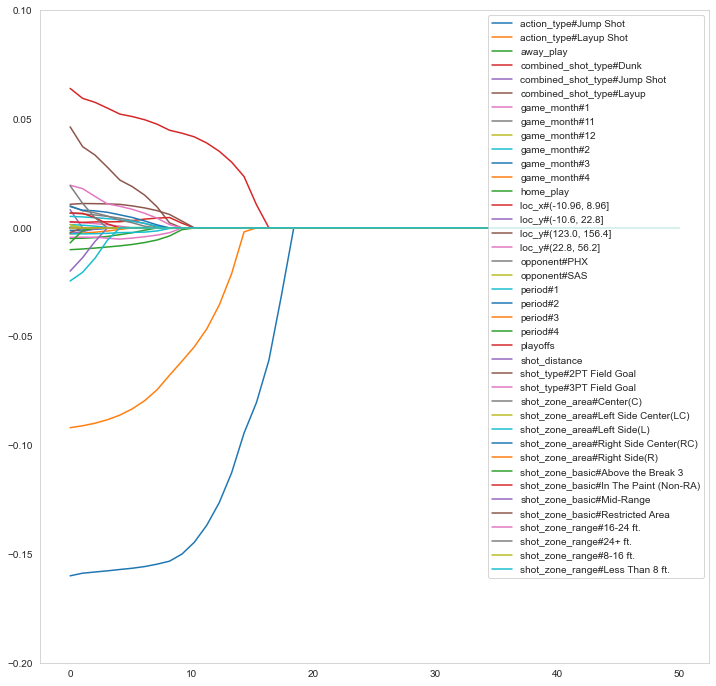

In [185]:
from sklearn.linear_model import  Lasso
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

X_sc = StandardScaler().fit_transform(X)
lg_l,pred_l = [], []

list_l=list(2**np.linspace(-10,10,50))

for i in range(len(list_l)):
    m_l = Lasso(alpha=list_l[i]).fit(X_sc, Y)
    lg_l.append(m_l)
    pred_l.append(m_l.coef_)

plt.figure(figsize=[12,12])
x_l = np.linspace(0,len(pred_l),len(pred_l))
for i in np.vstack(pred_l).T:
    plt.plot(x_l,np.sign(i)*np.abs(i)) 
plt.ylim(-0.2,0.1)  
plt.legend(ffeatures, loc='upper right')      
plt.grid()

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=5 )

Модель Lasso

In [207]:
Lasso_clf = linear_model.Lasso(alpha=0.1).fit(X_train, y_train)
Lasso_clf.score(X_test, y_test)

0.03638713780561398

модель Ridge:

In [194]:
from sklearn.linear_model import RidgeClassifier
ridge_clf = RidgeClassifier().fit(X_train, y_train)
ridge_clf.score(X_test, y_test)

0.6817120622568094

In [202]:
LDA_clf = LinearDiscriminantAnalysis()
LDA_clf.fit(X_train, y_train)
LDA_clf.score(X_test, y_test)

0.6817120622568094

Вывод:

То ли я что-то не то делаю и как-то не так понял задание, то ли модели одного класса (они ж все линейные классификаторы) отрабатывают не то, чьтобы очень хорошо.

Оставшаяся часть задания, как я понял, не обязательная, поэтому я ее не делал (если честно, просто не было времени)

<p style="align: center;"><img align=center src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTQuOv9Q44GZBxOzR_QTgDW3JkoUMiUFCd5gNzdsuApcrFr97dYa0KMYp-zKPOrkshFkm0&usqp=CAU"  width=500></p>